In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import transforms
from obspy.io.segy.segy import iread_segy

from dataset import  DatasetFromFolderCO2
from pix2pix import generator22
from pix2pix import discriminator_without_sigmoid22
from numpy import linalg as LA


In [ ]:
#Transforming seismorgam to frequency domain using FFT
def fft_for_segy(seismorgamma):
    seismorgamma = torch.tensor(seismorgamma)
    freq = torch.fft.fftfreq(len(seismorgamma[0]))
    seism_fft = torch.fft.fft2(seismorgamma, dim=1)
    seism_fft_positive = []
    for i in range(512):
        trace_fft = seism_fft[i]
        seism_fft_positive.append(trace_fft[freq>=0])
    seism_fft_positive = np.stack(seism_fft_positive)
    seism_fft_positive = torch.from_numpy(seism_fft_positive)
    seism_fft_positive = seism_fft_positive[:,:1024]
        
    return seism_fft_positive

#Folder where seismograms live
fileX = "S_5_uz.sgy"
fileY = "S_25_uz.sgy"


size_of_seismogram = 513
len_of_patch = 1

#folder where seismograms and seismograms in frequency domain live
pathX = 'Data_seism/S_gravity_5/'
if not os.path.isdir(pathX):
    os.mkdir(pathX)
        
pathY = 'Data_seism/S_gravity_25/'
if not os.path.isdir(pathY):
    os.mkdir(pathY)
    
fft_pathX = 'Data_fft/S_gravity_5/'
if not os.path.isdir(fft_pathX):
    os.mkdir(fft_pathX)
    
fft_pathY = 'Data_fft/S_gravity_25/'
if not os.path.isdir(fft_pathY):
    os.mkdir(fft_pathY)
    

In [ ]:
seismogramX = []
seismogramY = []

k = 0 #initial index (on the next monitoring step k = number_of_sources + N_m, where N_m is the number of monitoring step)
number_of_traces = 1
for traceX, traceY in zip(iread_segy(fileX),iread_segy(fileY)):
    
    seismogramX.append(traceX.data)
    seismogramY.append(traceY.data)
    if number_of_traces%size_of_seismogram == 0:
        seismogramX = np.stack(seismogramX)
        seismogramY = np.stack(seismogramY)
                
        np.save(pathX+str(k), seismogramX)
        np.save(pathY+str(k), seismogramY)
        
        seism_fft = fft_for_segy(seismogramX)
        np.save(fft_pathX+str(k), seism_fft)
        seism_fft = fft_for_segy(seismogramY)
        np.save(fft_pathY+str(k), seism_fft)
        print(k)
        k=k+1        
        seismogramX = []
        seismogramY = []
        diff_seismogram = []
         
    number_of_traces = number_of_traces + 1
    
    #break
        

In [ ]:
#MAXMIN VALUE
#run this twice to determine the maximum values of the two sets of seismograms

max_real = 0
min_real = 0
pathY = 'Data_fft/S_gravity_5/'

for k in range(0,875):
    data = np.load(pathY+str(k)+'.npy')
    data_next = np.load(pathY+str(k+125)+'.npy')
    
    tmp = np.max((data.real, data.imag))
    if tmp > max_real:
        max_real = tmp
        
    tmp = np.min((data.real, data.imag))
    if tmp < min_real:
        min_real = tmp

In [ ]:
#cuda available check
torch.cuda.is_available()
torch.cuda.device_count()
device = torch.device("cuda:1" if torch.cuda.is_available() else 'cpu:0')
print(device)
torch.cuda.set_device(device)


transTorch = transforms.Compose([
    transforms.ToTensor(), 
])

trans_target = transforms.Compose([
    transforms.ToTensor(),
])

cuda:1


In [ ]:
#initialize parameters
num_epochs = 100
lrG = 1e-4
lamb = 10
direction = 'AtoB'
batch_size = 10
ngf = 64 #relates to the depth of feature maps carried through the generator
input_size =  1024
crop_size = 256
fliplr = False
flipud = False
beta1 = 0.5
beta2 = 0.999

In [ ]:

X = fft_pathX
Y = fft_pathY

n_total_samples = 629-126
percent = 20
proportion = int(100/percent)
train_idx = range(0, n_total_samples, proportion)

print(len(train_idx))
Trainingpath = 'Results/S_gravity/'

Trainingpath0 = Trainingpath
if not os.path.isdir(Trainingpath):
    os.mkdir(Trainingpath)
train_dir = Trainingpath+'ed'
np.save(train_dir, train_idx)
train_dir = train_dir+'.npy'

101


In [ ]:
train_dir = Trainingpath+'ed.npy' #indexes of seismograms included in training dataset
batch_size = 3
max_value_xx=1
max_value_yy=0.95 

train_data = DatasetFromFolderCO2(X, Y, 
                                 train_dir,
                                 max_value_x=9976,
                                 max_value_y=7431,
                                 transform = transTorch, 
                                 transform_target= trans_target,
                                 number_of_sources=126,
                                 direction='AtoB',
                                 crop_size = 1024)

val_percent = 0.5
n_val = int(len(train_data)*val_percent)
n_train = len(train_data) - n_val
train_set, val_set = random_split(train_data, [n_train, n_val], generator=torch.Generator().manual_seed(0))
train_data_loader_G1 = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_data_loader_G1 = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()
L2_loss = torch.nn.MSELoss().cuda()
BCE_Logistic_loss = torch.nn.BCEWithLogitsLoss().cuda()

70.616005
torch.Size([3, 2, 512, 1024]) torch.Size([3, 2, 512, 1024])


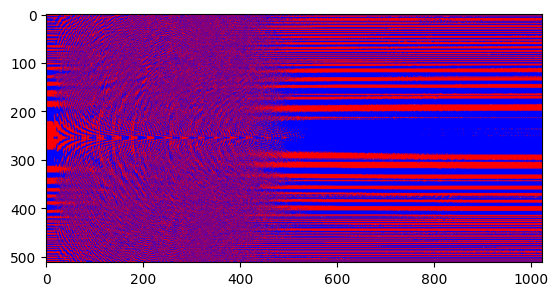

tensor(0.7181, device='cuda:1')
tensor(0.5574, device='cuda:1')


In [10]:
seism5, seism25, seism5_next, seism25_next = next(iter(train_data_loader_G1))
print(100*LA.norm(seism5.cpu().data-seism25.cpu().data)/LA.norm(seism25.cpu().data))
print(seism5.shape, seism25.shape)
delta = 1e-7
plt.imshow(seism25[0][0].cpu().data-seism5[0][0].cpu().data, 'bwr', vmin=-delta, vmax=delta)
plt.show()
print((seism25).max())
print((seism5).max())

In [12]:
lrG2 = 1e-5
lrD2 = 1e-7
G1 = generator22(64, input_dim=2,  output_dim = 2)
G1.cuda()
G1.weight_init(mean=0.0, std=0.02)
D1 = discriminator_without_sigmoid22(input_dim=4, out_dim=2)
D1.weight_init(mean = 0.0, std = 0.02)
D1.cuda()

G1_optimizer = torch.optim.Adam(G1.parameters(), lr = lrG2, betas = (beta1, beta2))
G1_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(G1_optimizer, factor = 0.5, patience = 10)
D1_optimizer = torch.optim.Adam(D1.parameters(), lr = lrD2, betas = (beta1, beta2))
D1_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(D1_optimizer,
                                                          factor = 0.5,
                                                          patience = 10)

G1_TrainingLoss = []
G1_ValidationLoss = []
D1_TrainingLoss = []
D1_ValidationLoss = []
G1.train()
D1.train()

discriminator_without_sigmoid22(
  (conv1): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 2, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [ ]:
#training NDM-net
num_epochs = 301
for epoch in range(0,num_epochs):
    G1_losses = []
    D1_losses = []
    for i, (seism_5, seism_25, seism_5_next, seism_25_next) in enumerate(train_data_loader_G1):
   
        seism_25 = Variable(seism_25.cuda()) 
        seism_5 = Variable(seism_5.cuda()) #x_1
        seism_25_next = Variable(seism_25_next.cuda()) 
        seism_5_next = Variable(seism_5_next.cuda()) #x_1
         
        ds_5 = (seism_5_next - seism_5)
        ds_25 = (seism_25_next - seism_25)
        
        ds_true = seism_25 - seism_5
        dds_true = ds_25 - ds_5
        
        x = torch.cat((seism_5,ds_5))
        y = torch.cat((seism_25,ds_25))
    
        
        #train D1
        D1_result = D1(x, y).squeeze()
        D_real_loss =  BCE_Logistic_loss(D1_result,
                                Variable(torch.ones(D1_result.size()).cuda()))
        
        
        G1_result = G1(x)
        D1_result = D1(x, G1_result).squeeze()
        D_fake_loss = BCE_Logistic_loss(D1_result,
                               Variable(torch.zeros(D1_result.size()).cuda()))
                
        D_train_loss =   (D_real_loss + D_fake_loss) * 0.5
        D_train_loss.backward()
        D1_optimizer.step()
        D1_optimizer.zero_grad()
        D1_losses.append(D_fake_loss.item())  
        
        #train G2 
        G1_result = G1(x)
        D_result = D1(x, G1_result).squeeze()
        G1_loss = BCE_Logistic_loss(D_result, Variable(torch.ones(D_result.size()).cuda())) + 10000 * L1_loss(G1_result, y)
        G1_losses.append(G1_loss.item())
        G1_loss.backward(retain_graph=True)
        G1_optimizer.step()
        G1_optimizer.zero_grad()
        
        
    G1_mean_loss = sum(G1_losses) / len(G1_losses)     
    G1_scheduler.step(G1_mean_loss)
    G1_TrainingLoss.append(G1_mean_loss)
    D1_mean_loss = sum(D1_losses) / len(D1_losses)     
    D1_scheduler.step(D1_mean_loss)
    D1_TrainingLoss.append(D1_mean_loss)
    
        
    G1.eval()
    D1.eval()
    G1_losses_val = []
    D1_losses_val = []
    for i, (seism_5, seism_25, seism_5_next, seism_25_next) in enumerate(val_data_loader_G1):
        seism_25 = Variable(seism_25.cuda()) 
        seism_5 = Variable(seism_5.cuda()) 
        seism_25_next = Variable(seism_25_next.cuda()) 
        seism_5_next = Variable(seism_5_next.cuda()) 
         
        ds_5 = (seism_5_next - seism_5)
        ds_25 = (seism_25_next - seism_25)
        
        ds_true = seism_25 - seism_5
        dds_true = ds_25 - ds_5
        
        x = torch.cat((seism_5,ds_5))
        y = torch.cat((seism_25,ds_25))
        
        #train D1 val
        D1_result = D1(x, y).squeeze()
        D_real_loss =  BCE_Logistic_loss(D1_result,
                                Variable(torch.ones(D1_result.size()).cuda()))
        
        
        G1_result = G1(x)
        D1_result = D1(x, G1_result).squeeze()
        D_fake_loss = BCE_Logistic_loss(D1_result,
                               Variable(torch.zeros(D1_result.size()).cuda()))
                
        D_train_loss =   (D_real_loss + D_fake_loss) * 0.5
        D_train_loss.backward()
        D1_optimizer.step()
        D1_optimizer.zero_grad()
        
        D1_losses_val.append(D_fake_loss.item())  
        
        #train G2 val
        G1_result = G1(x)
        D_result = D1(x, G1_result).squeeze()
        G1_loss = BCE_Logistic_loss(D_result, Variable(torch.ones(D_result.size()).cuda())) + 10000 * L1_loss(G1_result, y)
        G1_losses_val.append(G1_loss.item())
        G1_loss.backward(retain_graph=True)
        G1_optimizer.step()
        G1_optimizer.zero_grad()
        
        
    G1_mean_loss_val = sum(G1_losses_val)/len(G1_losses_val)
    G1_ValidationLoss.append(G1_mean_loss_val)
    G1_scheduler.step(G1_mean_loss_val)
    
    D1_mean_loss_val = sum(D1_losses_val)/len(D1_losses_val)
    D1_ValidationLoss.append(D1_mean_loss_val)
    D1_scheduler.step(D1_mean_loss_val)
    if epoch!=0 and epoch % 100 == 0:
        torch.save(G1.state_dict(), Trainingpath + 'G_' + str(epoch) + '.pkl')
        torch.save(D1.state_dict(), Trainingpath + 'D_' + str(epoch) + '.pkl')
        print(epoch, " save.")

100  save.


KeyboardInterrupt: 

In [14]:
plt.plot(G1_ValidationLoss/ np.max((G1_TrainingLoss, G1_ValidationLoss)), 
         label= r'Validation loss for $G$')
plt.plot(G1_TrainingLoss/ np.max((G1_TrainingLoss, G1_ValidationLoss)), 
         label = r'Training loss for $G$')
plt.legend(fontsize=15)
plt.grid(True)
plt.xlabel('Epoch', fontsize = 21)
plt.ylabel('Normilized error', fontsize = 21)
plt.show()

plt.plot(D1_ValidationLoss/ np.max((D1_ValidationLoss, D1_TrainingLoss)),
         label= r'Validation loss for $D$')
plt.plot(D1_TrainingLoss/ np.max((D1_ValidationLoss, D1_TrainingLoss)), 
         label = r'Training loss for $D$')
plt.legend(fontsize=15)
plt.grid(True)
plt.xlabel('Epoch', fontsize = 21)
plt.ylabel('Normilized error', fontsize = 21)
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [15]:
#if you need to load weights from saved Training path
G1.load_state_dict(torch.load(Trainingpath+"G_300.pkl"))
G1.eval()

generator22(
  (conv1): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(512, 512, kernel_size=(4

In [ ]:
#Analysis of test dataset
number_of_sources = 126
n_total_samples = 755-number_of_sources
percent = 100
proportion = int(100/percent)
test_idx = range(0, n_total_samples, proportion)
test_dir = Trainingpath+'edTest'
np.save(test_dir, test_idx)
test_dir = test_dir+'.npy'
print(len(test_idx))
test_dir = Trainingpath+'edTest.npy' #indexes of seismograms included in training dataset
batch_size = 1

X_all = 'X:/MonitoringCo2/Data_fft/S_gravity_5/'
Y_all = 'X:/MonitoringCo2/Data_fft/S_gravity_25/'

max_value_x = 9976
max_value_y = 7431

test_data = DatasetFromFolderCO2(X_all, Y_all, 
                                 test_dir,
                                 max_value_x=max_value_x,
                                 max_value_y=max_value_y,
                                 transform = transTorch, 
                                 transform_target= trans_target,
                                 number_of_sources=number_of_sources,
                                 direction='AtoB',
                                 crop_size = 1024)
test_data_loader_G1 = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)


G_kk_k = []
Y_kk_k=[]
X_kk_k=[]
XY_disp = []
GY_disp=[]
dXY_disp = []
dGY_disp = []

for i, (seism_5, seism_25, seism_5_next, seism_25_next) in enumerate(test_data_loader_G1):
        seism_25 = Variable(seism_25.cuda()) 
        seism_5 = Variable(seism_5.cuda())
        seism_25_next = Variable(seism_25_next.cuda()) 
        seism_5_next = Variable(seism_5_next.cuda())
         
        ds_5 = (seism_5_next - seism_5)
        ds_25 = (seism_25_next - seism_25)
        
        ds_true = ds_25 - ds_5
        x = torch.cat((seism_5,ds_5))
        y = torch.cat((seism_25,ds_25))
        
        
        g = (G1(x))*max_value_y#(G1(ds_5)+ds_5
        y=y*max_value_y
        x=x*max_value_x
        
        
        fft_g = torch.complex(g[0][0].cpu().data, g[0][1].cpu().data)
        tmp = fft_g
        tmp = torch.tensor(tmp)
        seism_fft_positive_for_lr = tmp[:,1:]
        seism_fft_positive = tmp
        seism_fft_positive = torch.tensor(seism_fft_positive)
        seism_fft_positive_for_lr = torch.tensor(seism_fft_positive_for_lr)
        tmp_zeros = torch.zeros(512,5000-1024-1023)
        seism_fft_new_real = torch.cat(((seism_fft_positive.real), tmp_zeros, torch.fliplr(seism_fft_positive_for_lr.real) ),1)
        seism_fft_imag = torch.cat( (seism_fft_positive.imag, tmp_zeros, torch.fliplr(-(seism_fft_positive_for_lr.imag)) ), 1 )
        seism_fft_new = torch.complex(seism_fft_new_real, seism_fft_imag)
        seism_new_new = torch.fft.ifft2(seism_fft_new,dim=1)
        G_k = seism_new_new.real
        
        fft_g = torch.complex(y[0][0].cpu().data, y[0][1].cpu().data)
        tmp = fft_g
        tmp = torch.tensor(tmp)
        seism_fft_positive_for_lr = tmp[:,1:]
        seism_fft_positive = tmp
        seism_fft_positive = torch.tensor(seism_fft_positive)
        seism_fft_positive_for_lr = torch.tensor(seism_fft_positive_for_lr)
        tmp_zeros = torch.zeros(512,5000-1024-1023)
        seism_fft_new_real = torch.cat(((seism_fft_positive.real), tmp_zeros, torch.fliplr(seism_fft_positive_for_lr.real) ),1)
        seism_fft_imag = torch.cat( (seism_fft_positive.imag, tmp_zeros, torch.fliplr(-(seism_fft_positive_for_lr.imag)) ), 1 )
        seism_fft_new = torch.complex(seism_fft_new_real, seism_fft_imag)
        seism_new_new = torch.fft.ifft2(seism_fft_new,dim=1)
        Y_k = seism_new_new.real
        
        fft_g = torch.complex(x[0][0].cpu().data, x[0][1].cpu().data)
        tmp = fft_g
        tmp = torch.tensor(tmp)
        seism_fft_positive_for_lr = tmp[:,1:]
        seism_fft_positive = tmp
        seism_fft_positive = torch.tensor(seism_fft_positive)
        seism_fft_positive_for_lr = torch.tensor(seism_fft_positive_for_lr)
        tmp_zeros = torch.zeros(512,5000-1024-1023)
        seism_fft_new_real = torch.cat(((seism_fft_positive.real), tmp_zeros, torch.fliplr(seism_fft_positive_for_lr.real) ),1)
        seism_fft_imag = torch.cat( (seism_fft_positive.imag, tmp_zeros, torch.fliplr(-(seism_fft_positive_for_lr.imag)) ), 1 )
        seism_fft_new = torch.complex(seism_fft_new_real, seism_fft_imag)
        seism_new_new = torch.fft.ifft2(seism_fft_new,dim=1)
        X_k = seism_new_new.real
        
        tmp_real = g[1][0] + g[0][0]#g[1][0]*0.41 + g[0][0]
        tmp_imag =  g[1][1]+g[0][1]#g[1][1]*0.41+g[0][1]
        fft_g = torch.complex(tmp_real.cpu().data, tmp_imag.cpu().data)
        tmp = fft_g
        tmp = torch.tensor(tmp)
        seism_fft_positive_for_lr = tmp[:,1:]
        seism_fft_positive = tmp
        seism_fft_positive = torch.tensor(seism_fft_positive)
        seism_fft_positive_for_lr = torch.tensor(seism_fft_positive_for_lr)
        tmp_zeros = torch.zeros(512,5000-1024-1023)
        seism_fft_new_real = torch.cat(((seism_fft_positive.real), tmp_zeros, torch.fliplr(seism_fft_positive_for_lr.real) ),1)
        seism_fft_imag = torch.cat( (seism_fft_positive.imag, tmp_zeros, torch.fliplr(-(seism_fft_positive_for_lr.imag)) ), 1 )
        seism_fft_new = torch.complex(seism_fft_new_real, seism_fft_imag)
        seism_new_new = torch.fft.ifft2(seism_fft_new,dim=1)
        G_kk = seism_new_new.real
        
        tmp_real = y[1][0] + y[0][0]
        tmp_imag =  y[1][1] + y[0][1]
        fft_g = torch.complex(tmp_real.cpu().data, tmp_imag.cpu().data)
        tmp = fft_g
        tmp = torch.tensor(tmp)
        seism_fft_positive_for_lr = tmp[:,1:]
        seism_fft_positive = tmp
        seism_fft_positive = torch.tensor(seism_fft_positive)
        seism_fft_positive_for_lr = torch.tensor(seism_fft_positive_for_lr)
        tmp_zeros = torch.zeros(512,5000-1024-1023)
        seism_fft_new_real = torch.cat(((seism_fft_positive.real), tmp_zeros, torch.fliplr(seism_fft_positive_for_lr.real) ),1)
        seism_fft_imag = torch.cat( (seism_fft_positive.imag, tmp_zeros, torch.fliplr(-(seism_fft_positive_for_lr.imag)) ), 1 )
        seism_fft_new = torch.complex(seism_fft_new_real, seism_fft_imag)
        seism_new_new = torch.fft.ifft2(seism_fft_new,dim=1)
        Y_kk = seism_new_new.real
        
        # tmp_real = x[1][0]*0.41 + x[0][0]
        # tmp_imag =  x[1][1]*0.41 + x[0][1]
        tmp_real = x[1][0] + x[0][0]
        tmp_imag =  x[1][1] + x[0][1]
        fft_g = torch.complex(tmp_real.cpu().data, tmp_imag.cpu().data)
        tmp = fft_g
        tmp = torch.tensor(tmp)
        seism_fft_positive_for_lr = tmp[:,1:]
        seism_fft_positive = tmp
        seism_fft_positive = torch.tensor(seism_fft_positive)
        seism_fft_positive_for_lr = torch.tensor(seism_fft_positive_for_lr)
        tmp_zeros = torch.zeros(512,5000-1024-1023)
        seism_fft_new_real = torch.cat(((seism_fft_positive.real), tmp_zeros, torch.fliplr(seism_fft_positive_for_lr.real) ),1)
        seism_fft_imag = torch.cat( (seism_fft_positive.imag, tmp_zeros, torch.fliplr(-(seism_fft_positive_for_lr.imag)) ), 1 )
        seism_fft_new = torch.complex(seism_fft_new_real, seism_fft_imag)
        seism_new_new = torch.fft.ifft2(seism_fft_new,dim=1)
        X_kk = seism_new_new.real
        
        G_kk_k.append(100*LA.norm(G_kk-Y_k)/LA.norm(Y_k))
        
        Y_kk_k.append(100*LA.norm(Y_kk-Y_k)/LA.norm(Y_k))
                
        X_kk_k.append(100*LA.norm(X_kk-X_k)/LA.norm(X_k))

        XY_disp.append(100*LA.norm(X_k-Y_k)/LA.norm(Y_k))
        GY_disp.append(100*LA.norm(G_k-Y_k)/LA.norm(Y_k))

        dX = X_kk - X_k
        dY = Y_kk - Y_k
        dG = G_kk - G_k

        dXY_disp.append(100*LA.norm(dX-dY)/LA.norm(Y_k))
        dGY_disp.append(100*LA.norm(dG-dY)/LA.norm(Y_k))
        
        
        #break

629


Text(0.5, 0, 'Индекс источника')

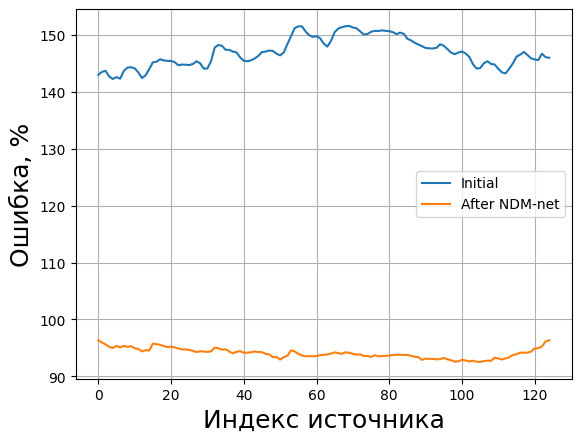

In [19]:
kk = 4
plt.plot(XY_disp[126*kk:126*(kk+1)], label = 'Initial')
plt.plot(GY_disp[126*kk:126*(kk+1)], label = 'After NDM-net')

plt.legend()
plt.grid(True)
plt.ylabel('Ошибка, %',fontsize = 18)
plt.xlabel('Индекс источника',fontsize = 18)

1.3354945
1.1112288
1.3707576


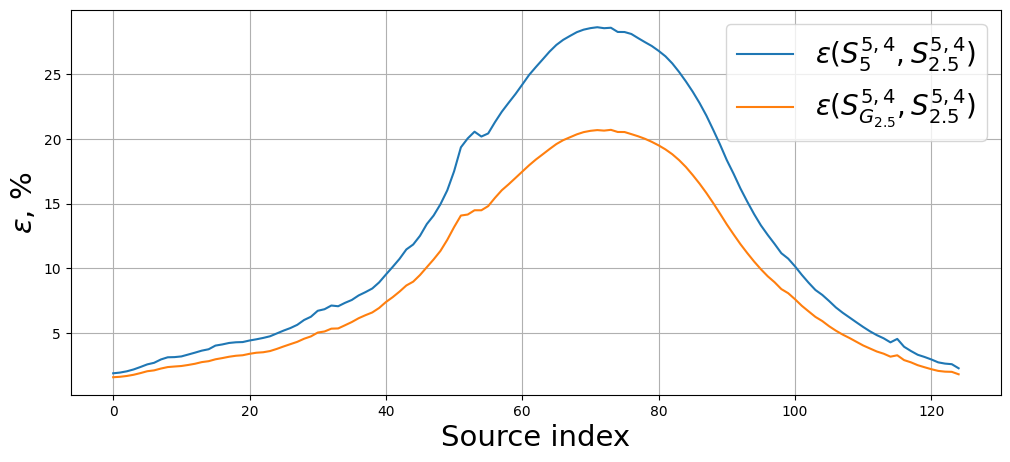

In [18]:
kk = 4
loss_xy = dXY_disp[126*kk:126*(kk+1)]
plt.figure(figsize=(12,5))
plt.plot(loss_xy, label = r'$\epsilon(S_5^{5,4},S_{2.5}^{5,4})$')
loss_gy = dGY_disp[126*kk:126*(kk+1)]
plt.plot(loss_gy, label = r'$\epsilon(S_{G_{2.5}}^{5,4},S_{2.5}^{5,4})$')


plt.legend(fontsize= 20)
plt.grid(True)
plt.ylabel(r'$\epsilon$, %',fontsize = 21)
plt.xlabel('Source index',fontsize = 21)

dXY_disp = np.array(dXY_disp)
dGY_disp = np.array(dGY_disp)
print(np.mean(dXY_disp / dGY_disp))

kk=3
loss_xy = dXY_disp[126*kk:126*(kk+1)]
loss_gy = dGY_disp[126*kk:126*(kk+1)]
print(np.mean(loss_xy/loss_gy))

dXY_disp = np.array(XY_disp)
dGY_disp = np.array(GY_disp)
print(np.mean(dXY_disp / dGY_disp))

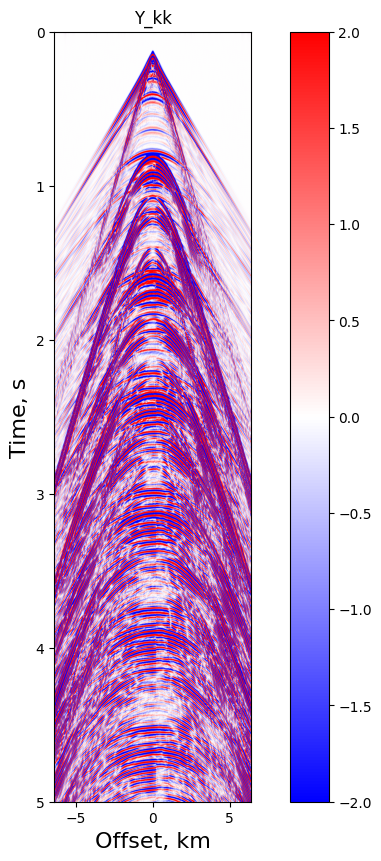

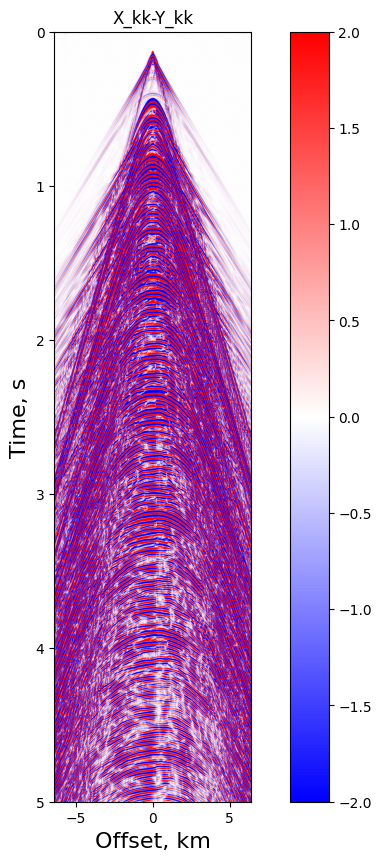

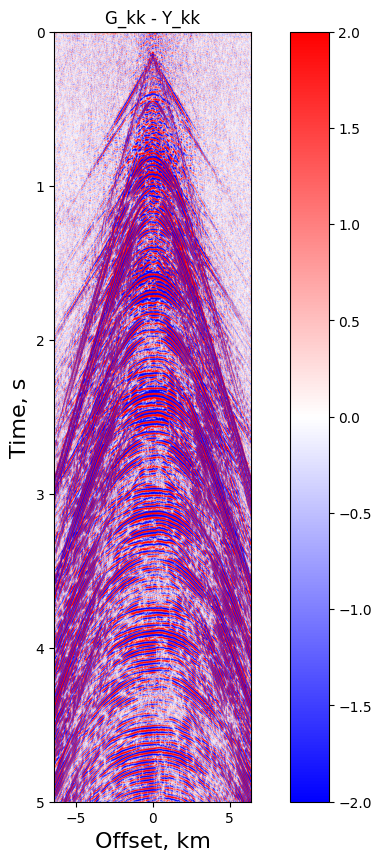

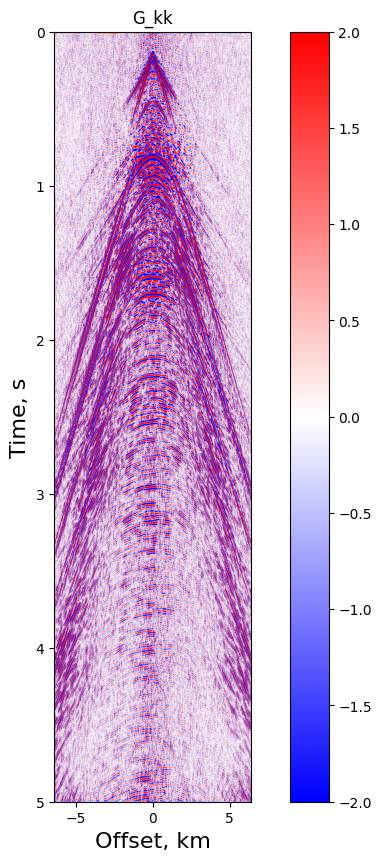

In [20]:
Y_kk = np.rot90(Y_kk)#*7.7e-15
Y_kk = np.rot90(Y_kk)
Y_kk = np.rot90(Y_kk)

Y_k = np.rot90(Y_k)#*7.7e-15
Y_k = np.rot90(Y_k)
Y_k = np.rot90(Y_k)


X_kk = np.rot90(X_kk)#*7.7e-15
X_kk = np.rot90(X_kk)
X_kk = np.rot90(X_kk)

X_k = np.rot90(X_k)#*7.7e-15
X_k = np.rot90(X_k)
X_k = np.rot90(X_k)

G_kk = np.rot90(G_kk)#*7.7e-15
G_kk = np.rot90(G_kk)
G_kk = np.rot90(G_kk)

G_k = np.rot90(G_k)#*7.7e-15
G_k = np.rot90(G_k)
G_k = np.rot90(G_k)


delta = 0.2e1
        
plt.figure(figsize=(10,10))
plt.imshow(Y_kk.real, 'bwr',extent=[-6.4,6.4,5,0], aspect = 10, vmin = -delta, vmax=delta)
plt.colorbar()
plt.xlabel('Offset, km',fontsize = 16)
plt.ylabel('Time, s',fontsize = 16)
plt.title('Y_kk')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(X_kk.real-Y_kk.real, 'bwr',extent=[-6.4,6.4,5,0], aspect = 10, vmin = -delta, vmax=delta)
plt.colorbar()
plt.xlabel('Offset, km',fontsize = 16)
plt.ylabel('Time, s',fontsize = 16)
plt.title('X_kk-Y_kk')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(G_kk.real-Y_kk.real, 'bwr',extent=[-6.4,6.4,5,0], aspect = 10, vmin = -delta, vmax=delta)
plt.colorbar()
plt.xlabel('Offset, km',fontsize = 16)
plt.ylabel('Time, s',fontsize = 16)
plt.title('G_kk - Y_kk')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(G_kk.real, 'bwr',extent=[-6.4,6.4,5,0], aspect = 10, vmin = -delta, vmax=delta)
plt.colorbar()
plt.xlabel('Offset, km',fontsize = 16)
plt.ylabel('Time, s',fontsize = 16)
plt.title('G_kk')
plt.show()